Bootstrapping for covariance analyses

In [2]:
import scipy.stats as s
import numpy as np
import matplotlib.pyplot as plt
from os import path
import seaborn as sns
import pandas as pd
import scipy.io as sio
import pingouin as pg
from copy import copy, deepcopy
from tqdm import tqdm
import platform

# Import project specific modules and enable automatic reloading
import sys
from pathlib import Path
import os
eraser_path = Path(os.getcwd()).parent
reinstatement_path = eraser_path.parent / 'FearReinstatement'
sys.path.append(str(eraser_path))
sys.path.append(str(reinstatement_path))
%load_ext autoreload
%autoreload 2

import eraser_reference as err
import er_plot_functions as er
from plotting import Fig, pretty_plot, FigMirror
import placefield_stability as pfs
import Placefields as pf
import discrimination as discr
import ca_traces as trc
import freezing_analysis as fa
from plotting import Fig, pretty_plot, FigMirror
from helpers import contiguous_regions
import covariance_analysis as cova
from stats_utils import resample, bootstrap_resample, get_bootstrap_prob, get_bootstrap_prob_paired
from subjects import save_df, load_df

In [3]:
group_data_dir = "/Users/nkinsky/Documents/BU/Working/Eraser" if platform.system() == "Darwin" else "/home/nkinsky/Dropbox (University of Michigan)/Eraser/GroupData"
group_data_dir = Path(group_data_dir)

In [4]:
def add_memory_designations(df_use, key_use="d1_d2", before=['-2_-1', '-1_4'], during=['4_1'], 
                            after=['1_2', '2_7']):
    """Add in designations for before, 4hr (during), and after ANI administration into your dataframe"""
    df = deepcopy(df_use)
    desig = ["" for a in df.itertuples()]
    
    def create_bool_array_from_list(bool_list):
        bool_out = False
        for b in bool_list:
            bool_out = np.bitwise_or(bool_out, b)
            
        return bool_out
    
    before_bool_list = [df[key_use] == bef for bef in before]
    before_ind = np.where(create_bool_array_from_list(before_bool_list))[0]
    during_bool_list = [df[key_use] == dur for dur in during]
    during_ind = np.where(create_bool_array_from_list(during_bool_list))[0]
    after_bool_list = [df[key_use] == aft for aft in after]
    after_ind = np.where(create_bool_array_from_list(after_bool_list))[0]
    
    for idd, d in enumerate(desig):
        if idd in before_ind:
            desig[idd] = "Before"
        elif idd in during_ind:
            desig[idd] = "4hr"
        elif idd in after_ind:
            desig[idd] = "After"

    df['Designation'] = desig
    
    return df

### Calculate covariance for all cells and for freeze cells, including any that go silent in later sessions 
(conservative, silent cells push down overall covariance)
Not tracked across days, could be different populations of cells on each day for these plots

In [21]:
# Set bin size
bin_size = 0.5 # sec
buffer_sec_plot = (4, 4)

In [ ]:
# Run through and tally covariance for all groups/neurons
all_cov = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                               neurons='all', keep_silent=True, buffer_sec=buffer_sec_plot)
freeze_silent_cov = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                               neurons='freeze_onset', keep_silent=True, buffer_sec=buffer_sec_plot)

In [ ]:
# Now z-score to baseline days (-2 and -1), add in columns and reorganize a bit
sigz_freeze_df, sigz_freeze_df_all = cova.cov_dict_to_df(freeze_silent_cov, baseline_dict_use=all_cov, include_silent=True,
                                                         return_all_cov=True)
sigz_freeze_df = add_memory_designations(sigz_freeze_df)
save_df(sigz_freeze_df_all, "cov_sigz_freeze_df_all")

sigz_all_df, sigz_all_df_all = cova.cov_dict_to_df(all_cov, baseline_dict_use=all_cov, include_silent=True, return_all_cov=True)
sigz_all_df = add_memory_designations(sigz_all_df)
save_df(sigz_all_df_all, "cov_sigz_df_all")

# Break out into 3 groups instead of grouping Learners and Non-Learners together
sigz3way_freeze_df = cova.cov_dict_to_df(freeze_silent_cov, baseline_dict_use=all_cov, include_silent=True, 
                                        group_ctrls=False)
sigz3way_freeze_df = add_memory_designations(sigz3way_freeze_df)

sigz3way_all_df = cova.cov_dict_to_df(all_cov, baseline_dict_use=all_cov, include_silent=True, group_ctrls=False)
sigz3way_all_df = add_memory_designations(sigz3way_all_df)


In [ ]:
# Sanity check - make sure mean of individual cells from _all_df matches mean pre-calculated in _df above
df_comp = sigz_freeze_df_all.groupby(["Group", "Mouse", "d1_d2"]).mean(numeric_only=True).reset_index()
df_comp["d1_d2"] = pd.Categorical(df_comp["d1_d2"], ["-2_-1", "-1_4", "4_1", "1_2", "2_7", "4_2"])
print(df_comp[df_comp.Mouse == "Marble07"].sort_values("d1_d2"))
print("")
print(sigz_freeze_df.head(6))

In [ ]:
# Same calculation for freeze cells but excluding peri-freeze times
freeze_silent_wo_frz_times = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                                        neurons='freeze_onset', keep_silent=True, 
                                                        exclude_events='freeze_onset', exclude_buffer=(2, 2),
                                                        buffer_sec=buffer_sec_plot)

# Now z-score to baseline days (-2 and -1), add in columns and reorganize a bit
sigz_wo_frz_times_df, sigz_wo_frz_times_df_all = cova.cov_dict_to_df(freeze_silent_wo_frz_times, baseline_dict_use=all_cov, 
                                                                     include_silent=True, group_ctrls=False, return_all_cov=True)
sigz_wo_frz_times_df = add_memory_designations(sigz_wo_frz_times_df)
save_df(sigz_wo_frz_times_df_all, "cov_sigz_freeze_wo_frz_times_df_all")

In [ ]:
# Look at all cell covariance w/o freeze times included
all_cov_wofrzt = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                            neurons='all', keep_silent=True, exclude_events='freeze_onset',
                                            exclude_buffer=(2, 2), buffer_sec=buffer_sec_plot)

# Now z-score to baseline days (-2 and -1), add in columns and reorganize a bit
sigz_all_wo_frz_times_df, sigz_all_wo_frz_times_df_all = cova.cov_dict_to_df(all_cov_wofrzt, baseline_dict_use=all_cov, 
                                                                             include_silent=True, group_ctrls=False, return_all_cov=True)
sigz_all_wo_frz_times_df = add_memory_designations(sigz_all_wo_frz_times_df)
save_df(sigz_all_wo_frz_times_df_all, "cov_sigz_wo_frz_times_df")

In [ ]:
# Calculate freeze cell covariance including freeze times only
freeze_silent_peri_frz_only = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                                         neurons='freeze_onset', keep_silent=True, 
                                                         buffer_sec=buffer_sec_use, keep_events='freeze_onset', 
                                                         keep_buffer=buffer_sec_use)
sigz_freeze_df_peri_frz_only, sigz_freeze_df_peri_frz_only_all = cova.cov_dict_to_df(freeze_silent_peri_frz_only, baseline_dict_use=all_cov, 
                                                                                 include_silent=True, group_ctrls=False, return_all_cov=True)
sigz_freeze_df_peri_frz_only = add_memory_designations(sigz_freeze_df_peri_frz_only)

save_df(sigz_freeze_df_peri_frz_only_all, "cov_sigz_freeze_df_peri_frz_only_all")

freeze_silent_peri_frz_only_ERmatch = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                                                 neurons='freeze_onset', keep_silent=True, 
                                                                 buffer_sec=buffer_sec_use, keep_events='freeze_onset', 
                                                                 keep_buffer=buffer_sec_use, match_event_num=True)
sigz_freeze_df_peri_frz_only_ERmatch, sigz_freeze_df_peri_frz_only_ERmatch_all = cova.cov_dict_to_df(freeze_silent_peri_frz_only_ERmatch, 
                                                                                                     baseline_dict_use=all_cov, 
                                                                                                     include_silent=True, group_ctrls=False,
                                                                                                     return_all_cov=True)
sigz_freeze_df_peri_frz_only_ERmatch = add_memory_designations(sigz_freeze_df_peri_frz_only_ERmatch)
save_df(sigz_freeze_df_peri_frz_only_ERmatch_all, "cov_sigz_freeze_df_peri_frz_only_ERmatch_all")

In [9]:
# For all cells in neutral arena
all_cov_open = cova.group_cov_across_days(bin_size=bin_size, arena1='Open', arena2='Open', neurons='all', 
                                          keep_silent=True, base_days=[-2, -1, 4, 1, 2, -1, 0], 
                                          reg_days=[-1, 4, 1, 2, 7, 0, 4])
sigz_all_open_df = cova.cov_dict_to_df(all_cov_open, baseline_dict_use=all_cov_open, include_silent=True)
sigz_all_open_df = add_memory_designations(sigz_all_open_df)

sigz_all_open_df, sigz_all_open_df_all = cova.cov_dict_to_df(all_cov_open, baseline_dict_use=all_cov_open, include_silent=True,
                                                             group_ctrls=False, return_all_cov=True)
sigz_all_open_df = add_memory_designations(sigz_all_open_df, before=['-2_-1'], during=['-1_0'], after=['0_4'] )
sigz_all_open_df['Designation'].iloc[sigz_all_open_df['Designation'] == '4hr'] = 'Day -1'
save_df(sigz_all_open_df_all, "cov_sigz_all_open_df_all")

/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_49079/3121053200.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  sigz_all_open_df['Designation'].iloc[sigz_all_open_df['Designation'] == '4hr'] = 'Day -1'
/var/folders/7g/v7xwy2

cov_sigz_all_open_df_all.csv saved


In [23]:
freeze_silent_open_peri_frz_only = cova.group_cov_across_days(bin_size=bin_size, arena1='Open', arena2='Open',
                                                         neurons='freeze_onset', keep_silent=True, 
                                                         buffer_sec=buffer_sec_plot, keep_events='freeze_onset', 
                                                         keep_buffer=buffer_sec_plot)

neutral_frz_df_mean, neutral_frz_df_all = cova.cov_dict_to_df(freeze_silent_open_peri_frz_only, baseline_dict_use=all_cov_open, 
                                                              include_silent=True, group_ctrls=False, return_all_cov=True)

Marble07: 0it [00:00, ?it/s]

No tunings found for Marble07 Open day -2: run .get_tuning_sig() and .save_sig_tuning()
No tunings found for Marble07 Open day -2: run .get_tuning_sig() and .save_sig_tuning()
calculating significant tuning for buffer_sec=(4, 4) and nperm=1000
generating permuted rasters - may take up to 1 minute


Marble07: 4it [00:26,  4.33s/it]

No tunings found for Marble07 Open day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble07: 6it [00:29,  4.97s/it]
Marble12: 0it [00:00, ?it/s]

No tunings found for Marble12 Open day -2: run .get_tuning_sig() and .save_sig_tuning()
No tunings found for Marble12 Open day -2: run .get_tuning_sig() and .save_sig_tuning()
calculating significant tuning for buffer_sec=(4, 4) and nperm=1000
generating permuted rasters - may take up to 1 minute


Marble12: 4it [00:11,  2.28s/it]

No tunings found for Marble12 Open day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble12: 6it [00:14,  2.47s/it]
Marble24: 0it [00:00, ?it/s]

/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181126_1_openfield: nbadpts = 18 max_in_a_row = 3
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181126_1_openfield: nbadpts = 18 max_in_a_row = 3
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181126_1_openfield: nbadpts = 18 max_in_a_row = 3
No tunings found for Marble24 Open day -2: run .get_tuning_sig() and .save_sig_tuning()
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181127_1_openfield: nbadpts = 10 max_in_a_row = 4
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181127_1_openfield: nbadpts = 10 max_in_a_row = 4
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181127_1_openfield: nbadpts = 10 max_in_a_row = 4
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181126_1_openfield: nbadpts = 18 max_in_a_row = 3
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181126_1_openfield

Marble24: 1it [00:17, 17.38s/it]

/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181127_1_openfield: nbadpts = 10 max_in_a_row = 4
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181127_1_openfield: nbadpts = 10 max_in_a_row = 4
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181127_1_openfield: nbadpts = 10 max_in_a_row = 4


Marble24: 2it [00:18,  8.04s/it]

/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181127_1_openfield: nbadpts = 10 max_in_a_row = 4
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181127_1_openfield: nbadpts = 10 max_in_a_row = 4


Marble24: 4it [00:21,  3.63s/it]

No tunings found for Marble24 Open day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble24: 6it [00:24,  4.12s/it]
Marble27: 0it [00:00, ?it/s]

No tunings found for Marble27 Open day -2: run .get_tuning_sig() and .save_sig_tuning()
No tunings found for Marble27 Open day -2: run .get_tuning_sig() and .save_sig_tuning()
calculating significant tuning for buffer_sec=(4, 4) and nperm=1000
generating permuted rasters - may take up to 1 minute


Marble27: 4it [00:18,  3.23s/it]

No tunings found for Marble27 Open day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble27: 6it [00:21,  3.65s/it]
Marble06: 0it [00:00, ?it/s]

No tunings found for Marble06 Open day -2: run .get_tuning_sig() and .save_sig_tuning()
No tunings found for Marble06 Open day -2: run .get_tuning_sig() and .save_sig_tuning()
calculating significant tuning for buffer_sec=(4, 4) and nperm=1000
generating permuted rasters - may take up to 1 minute


Marble06: 3it [00:31,  7.49s/it]

/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180421_1_openfield: nbadpts = 63 max_in_a_row = 38
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180421_1_openfield: nbadpts = 63 max_in_a_row = 38
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180421_1_openfield: nbadpts = 63 max_in_a_row = 38


Marble06: 4it [00:32,  5.18s/it]

/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180421_1_openfield: nbadpts = 63 max_in_a_row = 38
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180421_1_openfield: nbadpts = 63 max_in_a_row = 38
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180421_1_openfield: nbadpts = 63 max_in_a_row = 38
No position data found for Marble06 Open day 7, loading neural data only


Marble06: 5it [00:35,  4.38s/it]

/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180421_1_openfield: nbadpts = 63 max_in_a_row = 38
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180421_1_openfield: nbadpts = 63 max_in_a_row = 38
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180421_1_openfield: nbadpts = 63 max_in_a_row = 38
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180421_1_openfield: nbadpts = 63 max_in_a_row = 38
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180421_1_openfield: nbadpts = 63 max_in_a_row = 38


Marble06: 6it [00:37,  6.21s/it]
Marble11: 0it [00:00, ?it/s]

No tunings found for Marble11 Open day -2: run .get_tuning_sig() and .save_sig_tuning()
No tunings found for Marble11 Open day -2: run .get_tuning_sig() and .save_sig_tuning()
calculating significant tuning for buffer_sec=(4, 4) and nperm=1000
generating permuted rasters - may take up to 1 minute


Marble11: 4it [00:47,  7.17s/it]

No tunings found for Marble11 Open day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble11: 6it [00:50,  8.44s/it]
Marble29: 0it [00:00, ?it/s]

No tunings found for Marble29 Open day -2: run .get_tuning_sig() and .save_sig_tuning()
No tunings found for Marble29 Open day -2: run .get_tuning_sig() and .save_sig_tuning()
calculating significant tuning for buffer_sec=(4, 4) and nperm=1000
generating permuted rasters - may take up to 1 minute


Marble29: 4it [00:43,  6.71s/it]

No tunings found for Marble29 Open day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble29: 6it [00:46,  7.71s/it]
Marble17: 0it [00:00, ?it/s]

No tunings found for Marble17 Open day -2: run .get_tuning_sig() and .save_sig_tuning()
No tunings found for Marble17 Open day -2: run .get_tuning_sig() and .save_sig_tuning()
calculating significant tuning for buffer_sec=(4, 4) and nperm=1000
generating permuted rasters - may take up to 1 minute


Marble17: 4it [00:53,  8.04s/it]

No tunings found for Marble17 Open day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble17: 6it [00:57,  9.52s/it]
Marble18: 0it [00:00, ?it/s]

No tunings found for Marble18 Open day -2: run .get_tuning_sig() and .save_sig_tuning()
No tunings found for Marble18 Open day -2: run .get_tuning_sig() and .save_sig_tuning()
calculating significant tuning for buffer_sec=(4, 4) and nperm=1000
generating permuted rasters - may take up to 1 minute


Marble18: 4it [00:12,  2.34s/it]

No tunings found for Marble18 Open day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble18: 6it [00:15,  2.51s/it]
Marble19: 0it [00:00, ?it/s]

No tunings found for Marble19 Open day -2: run .get_tuning_sig() and .save_sig_tuning()
No tunings found for Marble19 Open day -2: run .get_tuning_sig() and .save_sig_tuning()
calculating significant tuning for buffer_sec=(4, 4) and nperm=1000
generating permuted rasters - may take up to 1 minute


Marble19: 4it [00:38,  5.96s/it]

No tunings found for Marble19 Open day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble19: 6it [00:41,  6.98s/it]
Marble20: 0it [00:00, ?it/s]

No tunings found for Marble20 Open day -2: run .get_tuning_sig() and .save_sig_tuning()
No tunings found for Marble20 Open day -2: run .get_tuning_sig() and .save_sig_tuning()
calculating significant tuning for buffer_sec=(4, 4) and nperm=1000
generating permuted rasters - may take up to 1 minute


Marble20: 4it [00:15,  2.75s/it]

No tunings found for Marble20 Open day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble20: 6it [00:18,  3.07s/it]
Marble25: 0it [00:00, ?it/s]

/Users/nkinsky/Documents/BU/Working/Eraser/Anisomycin Group/Marble25/20181203_1_openfield: nbadpts = 9 max_in_a_row = 6
/Users/nkinsky/Documents/BU/Working/Eraser/Anisomycin Group/Marble25/20181203_1_openfield: nbadpts = 9 max_in_a_row = 6
/Users/nkinsky/Documents/BU/Working/Eraser/Anisomycin Group/Marble25/20181203_1_openfield: nbadpts = 9 max_in_a_row = 6
No tunings found for Marble25 Open day -2: run .get_tuning_sig() and .save_sig_tuning()
/Users/nkinsky/Documents/BU/Working/Eraser/Anisomycin Group/Marble25/20181203_1_openfield: nbadpts = 9 max_in_a_row = 6
/Users/nkinsky/Documents/BU/Working/Eraser/Anisomycin Group/Marble25/20181203_1_openfield: nbadpts = 9 max_in_a_row = 6
No tunings found for Marble25 Open day -2: run .get_tuning_sig() and .save_sig_tuning()
calculating significant tuning for buffer_sec=(4, 4) and nperm=1000
generating permuted rasters - may take up to 1 minute


Marble25: 4it [00:51,  7.68s/it]

No tunings found for Marble25 Open day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble25: 6it [00:54,  9.10s/it]


In [26]:
neutral_frz_df_mean

,d1_d2,Group,cov_z_mean
0,-2_-1,Learners,0.107788
1,-1_4,Learners,0.130182
2,4_1,Learners,0.038578
3,1_2,Learners,0.389739
4,2_7,Learners,0.168739
...,...,...,...
67,-1_4,ANI,0.101488
68,4_1,ANI,1.660931
69,1_2,ANI,0.412801
70,2_7,ANI,0.381908


<Axes: xlabel='Designation', ylabel='cov_z_mean'>

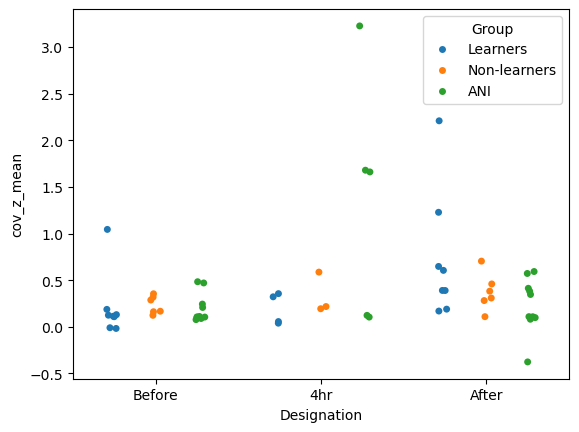

In [35]:
_, ax = plt.subplots()
df_use = add_memory_designations(neutral_frz_df_mean)
df_use["Designation"] = pd.Categorical(df_use["Designation"], ["Before", "4hr", "After"])
sns.stripplot(data=df_use, x="Designation", y="cov_z_mean", hue="Group", dodge=True, ax=ax)

In [34]:
df_use = add_memory_designations(neutral_frz_df_mean)
# df_use["Group"] = pd.Categorical(df_use["Group"], ["Before", "4hr", "After"])
df_use

,d1_d2,Group,cov_z_mean,Designation
0,-2_-1,Learners,0.107788,Before
1,-1_4,Learners,0.130182,Before
2,4_1,Learners,0.038578,4hr
3,1_2,Learners,0.389739,After
4,2_7,Learners,0.168739,After
...,...,...,...,...
67,-1_4,ANI,0.101488,Before
68,4_1,ANI,1.660931,4hr
69,1_2,ANI,0.412801,After
70,2_7,ANI,0.381908,After


### Bootstrap

#### Define function(s) for bootstrapping

In [12]:
def bootstrap_covariance(df, niter=10000, n_jobs=7, apply=lambda df2: df2.groupby("Group").mean(numeric_only=True).reset_index()):
    """Bootstrap each group during Before (Days -2 and -1), 4hr, and After (Days 1 and 2) epochs.  Only choose one day from each animal
    for the before and after epochs."""

    df_list = []
    for group_name in df.Group.unique():
        print(f"Bootstrapping for {group_name} group")
        for epoch in ["Before", "4hr", "After"]:
            if epoch == "Before":
                df_use = df[(df.Group == group_name) & ((df.d1_d2 == "-2_-1") | (df.d1_d2 == "-1_4"))]
            elif epoch == "4hr":
                df_use = df[(df.Group == group_name) & (df.d1_d2 == "4_1")]
            elif epoch == "After":
                df_use = df[(df.Group == group_name) & ((df.d1_d2 == "1_2") | (df.d1_d2 == "2_7"))]
            
            df_boot_temp = bootstrap_resample(df_use, niter, n_jobs=n_jobs, level=["Mouse", "d1_d2", "covz"], 
                                              n_level=[None, 1, None], apply=apply)
            df_boot_temp["Epoch"] = epoch
            
            df_list.append(df_boot_temp)
    
    df_boot_out = pd.concat(df_list, axis=0).reset_index()

    return df_boot_out

#### For all cells without freeze start times included

Bootstrapping for Learners group


100%|█████████████████████████████████████| 10000/10000 [05:57<00:00, 27.95it/s]


Bootstrapping for Non-learners group


100%|█████████████████████████████████████| 10000/10000 [17:51<00:00,  9.33it/s]


Bootstrapping for ANI group


100%|█████████████████████████████████████| 10000/10000 [13:35<00:00, 12.27it/s]


sigz_all_wo_frz_times_boot.csv saved


Text(0.5, 1.0, 'Re-load Check')

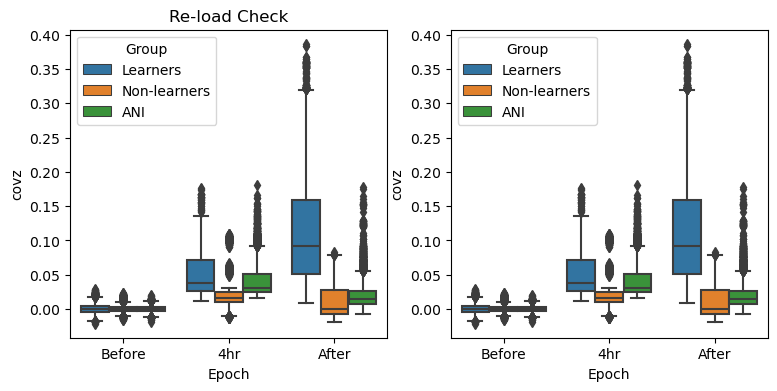

In [5]:
sigz_all_wo_frz_times_df_all = load_df("cov_sigz_wo_frz_times_df", save_dir=group_data_dir)
df_boot = bootstrap_covariance(sigz_all_wo_frz_times_df_all, niter=10000, n_jobs=12)

# Plot, save, and re-plot to check if saved properly
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.boxplot(data=df_boot, x="Epoch", y="covz", hue="Group", ax=ax[0])
ax[0].set_title("Original Run")

# Save
save_df(df_boot, "cov_sigz_all_wo_frz_times_boot", save_dir=group_data_dir)

# Replot
df_check = load_df("cov_sigz_all_wo_frz_times_boot", save_dir=group_data_dir)
sns.boxplot(data=df_check, x="Epoch", y="covz", hue="Group", ax=ax[1])
ax[0].set_title("Re-load Check")

#### For all cells with all times included

Bootstrapping for Learners group


100%|█████████████████████████████████████| 10000/10000 [05:52<00:00, 28.38it/s]


Bootstrapping for Non-learners group


100%|█████████████████████████████████████| 10000/10000 [17:49<00:00,  9.35it/s]


Bootstrapping for ANI group


100%|█████████████████████████████████████| 10000/10000 [13:24<00:00, 12.44it/s]


cov_sigz_boot_df_boot.csv saved


Text(0.5, 1.0, 'Re-load Check')

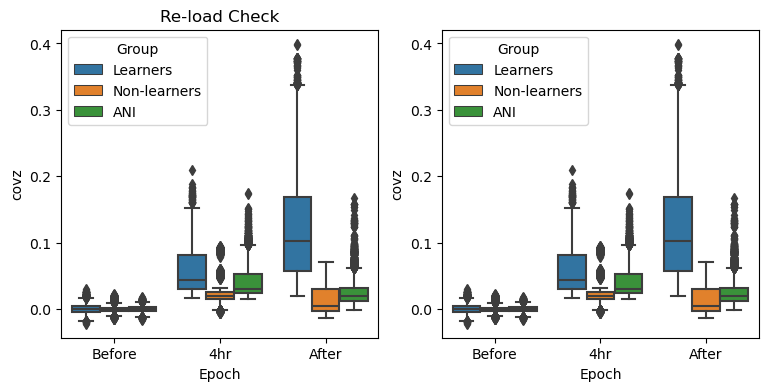

In [14]:
niter = 10000
n_jobs = 12
file_name = "cov_sigz_df_all"
df_use = load_df(file_name, save_dir=group_data_dir)
df_boot = bootstrap_covariance(df_use, niter=niter, n_jobs=n_jobs)

# Plot, save, and re-plot to check if saved properly
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.boxplot(data=df_boot, x="Epoch", y="covz", hue="Group", ax=ax[0])
ax[0].set_title("Original Run")

# Save
save_df(df_boot, file_name.replace("all", "boot"), save_dir=group_data_dir)

# Replot
df_check = load_df(file_name.replace("all", "boot"), save_dir=group_data_dir)
sns.boxplot(data=df_check, x="Epoch", y="covz", hue="Group", ax=ax[1])
ax[0].set_title("Re-load Check")

#### For Freeze cells with all times included

Bootstrapping for Learners group


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1047.22it/s]


Bootstrapping for Non-learners group


100%|████████████████████████████████████| 10000/10000 [00:12<00:00, 801.68it/s]


Bootstrapping for ANI group


100%|████████████████████████████████████| 10000/10000 [00:15<00:00, 656.58it/s]


cov_sigz_freeze_df_boot.csv saved


Text(0.5, 1.0, 'Re-load Check')

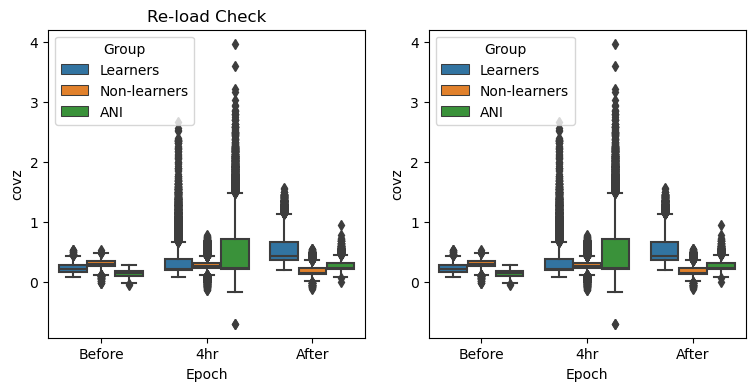

In [15]:
niter = 10000
n_jobs = 12
file_name = "cov_sigz_freeze_df_all"
df_use = load_df(file_name, save_dir=group_data_dir)
df_boot = bootstrap_covariance(df_use, niter=niter, n_jobs=n_jobs)

# Plot, save, and re-plot to check if saved properly
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.boxplot(data=df_boot, x="Epoch", y="covz", hue="Group", ax=ax[0])
ax[0].set_title("Original Run")

# Save
save_df(df_boot, file_name.replace("all", "boot"), save_dir=group_data_dir)

# Replot
df_check = load_df(file_name.replace("all", "boot"), save_dir=group_data_dir)
sns.boxplot(data=df_check, x="Epoch", y="covz", hue="Group", ax=ax[1])
ax[0].set_title("Re-load Check")

#### For Freeze cells with all times included

Bootstrapping for Learners group


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1036.91it/s]


Bootstrapping for Non-learners group


100%|████████████████████████████████████| 10000/10000 [00:12<00:00, 827.75it/s]


Bootstrapping for ANI group


100%|████████████████████████████████████| 10000/10000 [00:15<00:00, 640.37it/s]


cov_sigz_wo_frz_times_df_boot.csv saved


Text(0.5, 1.0, 'Re-load Check')

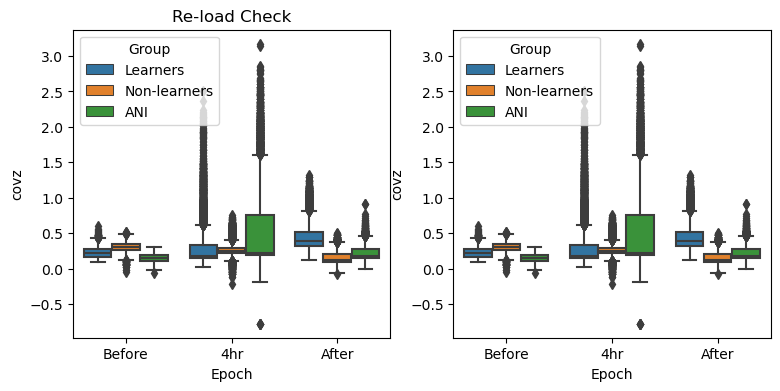

In [16]:
niter = 10000
n_jobs = 12
file_name = "cov_sigz_freeze_wo_frz_times_df_all"
df_use = load_df(file_name, save_dir=group_data_dir)
df_boot = bootstrap_covariance(df_use, niter=niter, n_jobs=n_jobs)

# Plot, save, and re-plot to check if saved properly
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.boxplot(data=df_boot, x="Epoch", y="covz", hue="Group", ax=ax[0])
ax[0].set_title("Original Run")

# Save
save_df(df_boot, file_name.replace("all", "boot"), save_dir=group_data_dir)

# Replot
df_check = load_df(file_name.replace("all", "boot"), save_dir=group_data_dir)
sns.boxplot(data=df_check, x="Epoch", y="covz", hue="Group", ax=ax[1])
ax[0].set_title("Re-load Check")

#### For freeze cells only during peri-freeze times

In [ ]:
niter = 10000
n_jobs = 12
file_name = "cov_sigz_freeze_df_peri_frz_only_all"
df_use = load_df(file_name, save_dir=group_data_dir)
df_boot = bootstrap_covariance(df_use, niter=niter, n_jobs=n_jobs)

# Plot, save, and re-plot to check if saved properly
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.boxplot(data=df_boot, x="Epoch", y="covz", hue="Group", ax=ax[0])
ax[0].set_title("Original Run")

# Save
save_df(df_boot, file_name.replace("all", "boot"), save_dir=group_data_dir)

# Replot
df_check = load_df(file_name.replace("all", "boot"), save_dir=group_data_dir)
sns.boxplot(data=df_check, x="Epoch", y="covz", hue="Group", ax=ax[1])
ax[0].set_title("Re-load Check")

#### For freeze cells at peri-freeze times only after matching event numbers between groups

In [ ]:
niter = 10000
n_jobs = 12
file_name = "cov_sigz_freeze_df_peri_frz_only_ERmatch_all"
df_use = load_df(file_name, save_dir=group_data_dir)
df_boot = bootstrap_covariance(df_use, niter=niter, n_jobs=n_jobs)

# Plot, save, and re-plot to check if saved properly
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.boxplot(data=df_boot, x="Epoch", y="covz", hue="Group", ax=ax[0])
ax[0].set_title("Original Run")

# Save
save_df(df_boot, file_name.replace("all", "boot"), save_dir=group_data_dir)

# Replot
df_check = load_df(file_name.replace("all", "boot"), save_dir=group_data_dir)
sns.boxplot(data=df_check, x="Epoch", y="covz", hue="Group", ax=ax[1])
ax[0].set_title("Re-load Check")

#### For all cells in neutral arena

Bootstrapping for Learners group


  3%|█▎                                     | 328/10000 [00:34<15:39, 10.30it/s]/Users/nkinsky/mambaforge/envs/eraser/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
  5%|█▉                                     | 496/10000 [00:50<17:21,  9.13it/s]/Users/nkinsky/mambaforge/envs/eraser/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 15%|█████▌                                | 1454/10000 [02:33<16:05,  8.85it/s]/Users/nkinsky/mambaforge/envs/eraser/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a t

Bootstrapping for Non-learners group


 48%|██████████████████                    | 4753/10000 [28:32<20:54,  4.18it/s]/Users/nkinsky/mambaforge/envs/eraser/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 48%|██████████████████▏                   | 4795/10000 [28:51<34:06,  2.54it/s]/Users/nkinsky/mambaforge/envs/eraser/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 65%|████████████████████████▊             | 6541/10000 [39:11<29:06,  1.98it/s]/Users/nkinsky/mambaforge/envs/eraser/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a t

Bootstrapping for ANI group


100%|█████████████████████████████████████| 10000/10000 [28:36<00:00,  5.83it/s]


cov_sigz_boot_open_df_boot.csv saved


Text(0.5, 1.0, 'Re-load Check')

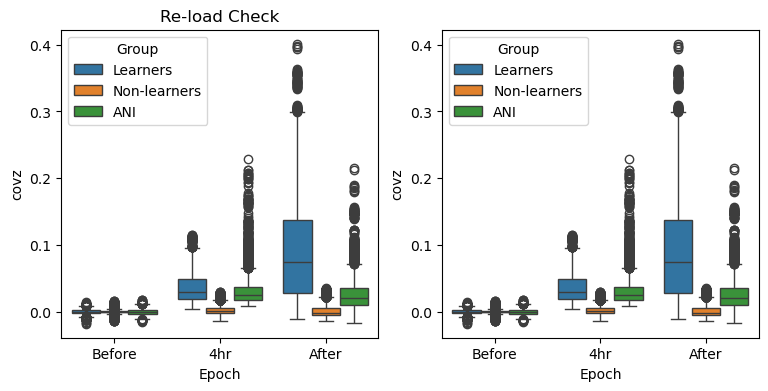

In [13]:
sigz_all_open_df_all
niter = 10000
n_jobs = 6
file_name = "cov_sigz_all_open_df_all"
df_use = load_df(file_name, save_dir=group_data_dir)
df_boot = bootstrap_covariance(df_use, niter=niter, n_jobs=n_jobs)

# Plot, save, and re-plot to check if saved properly
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.boxplot(data=df_boot, x="Epoch", y="covz", hue="Group", ax=ax[0])
ax[0].set_title("Original Run")

# Save
save_df(df_boot, file_name.replace("all", "boot"), save_dir=group_data_dir)

# Replot
df_check = load_df(file_name.replace("all", "boot"), save_dir=group_data_dir)
sns.boxplot(data=df_check, x="Epoch", y="covz", hue="Group", ax=ax[1])
ax[0].set_title("Re-load Check")

#### For all cells in the neutral arena before conditioning
To test if increases in covariance naturally occur before conditioning

In [ ]:
def bootstrap_covariance_neutral_before(df, niter=10000, n_jobs=7, 
                                        apply=lambda df2: df2.groupby("Group").mean(numeric_only=True).reset_index()):
    """Bootstrap each group during in neutral environment before conditioning on Day -2, Day -1, and Day 0"""

    df_list = []
    for group_name in df.Group.unique():
        print(f"Bootstrapping for {group_name} group")
        for epoch in ["Day -2", "Day -1", "Day 0"]:
            if epoch == "Day -2":
                df_use = df[(df.Group == group_name) & (df.d1_d2 == "-2_-1")]
            elif epoch == "Day -1":
                df_use = df[(df.Group == group_name) & (df.d1_d2 == "-1_0")]
            elif epoch == "Day 0":
                df_use = df[(df.Group == group_name) & (df.d1_d2 == "0_4")]
            
            df_boot_temp = bootstrap_resample(df_use, niter, n_jobs=n_jobs, level=["Mouse", "d1_d2", "covz"], 
                                              n_level=[None, 1, None], apply=apply)
            df_boot_temp["Epoch"] = epoch
            
            df_list.append(df_boot_temp)
    
    df_boot_out = pd.concat(df_list, axis=0).reset_index()

    return df_boot_out

In [ ]:
sigz_all_open_df_all
niter = 10000
n_jobs = 6
file_name = "cov_sigz_all_open_df_all"
df_use = load_df(file_name, save_dir=group_data_dir)
file_name = "cov_sigz_all_open_df_before_cond_all"  # Rename everything for clarity
save_df(df_use, file_name)
df_boot = bootstrap_covariance(df_use, niter=niter, n_jobs=n_jobs)

# Plot, save, and re-plot to check if saved properly
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.boxplot(data=df_boot, x="Epoch", y="covz", hue="Group", ax=ax[0])
ax[0].set_title("Original Run")

# Save
save_df(df_boot, file_name.replace("all", "boot"), save_dir=group_data_dir)

# Replot
df_check = load_df(file_name.replace("all", "boot"), save_dir=group_data_dir)
sns.boxplot(data=df_check, x="Epoch", y="covz", hue="Group", ax=ax[1])
ax[0].set_title("Re-load Check")

### Now bootstrap tracking freeze cells across days

In [ ]:
def bootstrap_covariance_across_days(df, niter=10000, n_jobs=7, before_strs=["4_-2", "4_-1"], during_strs=["4_4"], after_strs=["4_1", "4_2"],
                                     apply=lambda df2: df2.groupby("Group").mean(numeric_only=True).reset_index()):
    """Bootstrap each group across days"""

    df_list = []
    for group_name in df.Group.unique():
        print(f"Bootstrapping for {group_name} group")
        for epoch in ["Day -2", "Day -1", "Day 0"]:
            if epoch == "Day -2":
                df_use = df[(df.Group == group_name) & ((df.d1_d2 == before_strs[0]) | (df.d1_d2 == before_strs[1]))]
            elif epoch == "Day -1":
                df_use = df[(df.Group == group_name) & (df.d1_d2 == during_strs[0])]
            elif epoch == "Day 0":
                df_use = df[(df.Group == group_name) & ((df.d1_d2 == after_strs[0]) | (df.d1_d2 == after_strs[1]))]
            
            df_boot_temp = bootstrap_resample(df_use, niter, n_jobs=n_jobs, level=["Mouse", "d1_d2", "covz"], 
                                              n_level=[None, 1, None], apply=apply)
            df_boot_temp["Epoch"] = epoch
            
            df_list.append(df_boot_temp)
    
    df_boot_out = pd.concat(df_list, axis=0).reset_index()

    return df_boot_out

In [ ]:
niter = 10000
n_jobs = 12
file_name = "cov_sig4_df_reg_all"
df_use = load_df(file_name, save_dir=group_data_dir)
df_boot = bootstrap_covariance_across_days(df_use, niter=niter, n_jobs=n_jobs)

# Plot, save, and re-plot to check if saved properly
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.boxplot(data=df_boot, x="Epoch", y="covz", hue="Group", ax=ax[0])
ax[0].set_title("Original Run")

# Save
save_df(df_boot, file_name.replace("all", "boot"), save_dir=group_data_dir)

# Replot
df_check = load_df(file_name.replace("all", "boot"), save_dir=group_data_dir)
sns.boxplot(data=df_check, x="Epoch", y="covz", hue="Group", ax=ax[1])
ax[0].set_title("Re-load Check")

In [ ]:
niter = 10000
n_jobs = 12
file_name = "cov_sig1_df_reg_all"
df_use = load_df(file_name, save_dir=group_data_dir)
df_boot = bootstrap_covariance_across_days(df_use, niter=niter, n_jobs=n_jobs)

# Plot, save, and re-plot to check if saved properly
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.boxplot(data=df_boot, x="Epoch", y="covz", hue="Group", ax=ax[0])
ax[0].set_title("Original Run")

# Save
save_df(df_boot, file_name.replace("all", "boot"), save_dir=group_data_dir)

# Replot
df_check = load_df(file_name.replace("all", "boot"), save_dir=group_data_dir)
sns.boxplot(data=df_check, x="Epoch", y="covz", hue="Group", ax=ax[1])
ax[0].set_title("Re-load Check")

In [17]:
df_mean = df_use.groupby(["Group", "Mouse", "d1_d2"]).mean().reset_index()

In [18]:
add_memory_designations(df_mean)

,Group,Mouse,d1_d2,covz,Designation
0,ANI,Marble17,-1_0,0.000663,
1,ANI,Marble17,-1_4,0.000663,Before
2,ANI,Marble17,-2_-1,-0.000670,Before
3,ANI,Marble17,0_4,-0.004946,
4,ANI,Marble17,1_2,0.000633,After
...,...,...,...,...,...
79,Non-learners,Marble29,-2_-1,0.001737,Before
80,Non-learners,Marble29,0_4,0.000621,
81,Non-learners,Marble29,1_2,0.021691,After
82,Non-learners,Marble29,2_7,0.031571,After


<Axes: xlabel='Designation', ylabel='covz'>

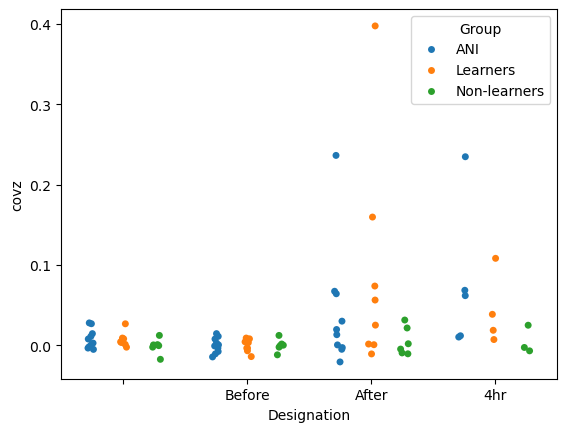

In [19]:
_, ax = plt.subplots()
sns.stripplot(data=add_memory_designations(df_mean), x="Designation", y="covz", hue="Group", dodge=True, ax=ax)

In [ ]:
save_df(df_boot, "sigz_wo_frz_times_boot")
df_check = load_df("sigz_wo_frz_times_boot")
_, ax = plt.subplots()
sns.boxplot(data=df_check, x="Epoch", y="covz", hue="Group", ax=ax)

In [ ]:
func = lambda df2: df2.groupby("Group").mean(numeric_only=True).reset_index()
df = sigz_all_wo_frz_times_df_all
n_iter = 10000

df_list = []
for group_name in df.Group.unique():
    print(f"Bootstrapping for {group_name} group")
    for epoch in ["Before", "4hr", "After"]:
        if epoch == "Before":
            df_use = df[(df.Group == group_name) & ((df.d1_d2 == "-2_-1") | (df.d1_d2 == "-1_4"))]
        elif epoch == "4hr":
            df_use = df[(df.Group == group_name) & (df.d1_d2 == "4_1")]
        elif epoch == "After":
            df_use = df[(df.Group == group_name) & ((df.d1_d2 == "1_2") | (df.d1_d2 == "2_7"))]
        
        df_boot_temp = bootstrap_resample(df_use, 100, n_jobs=7, level=["Mouse", "d1_d2", "covz"], n_level=[None, 1, None], apply=func)
        df_boot_temp["Epoch"] = epoch
        
        df_list.append(df_boot_temp)

df_boot = pd.concat(df_list, axis=0).reset_index()
df_boot